<a href="https://colab.research.google.com/github/michalis0/DataScience_and_MachineLearning/blob/master/Week_6/Week_6_solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install wikipedia
!pip install -q transformers
%pip install ipywidgets

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Import standard libraries
import pandas as pd
import numpy as np
import math
import bs4 as bs
import urllib.request
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

# Import for text analytics
import spacy
from spacy import displacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import string
import wikipedia
import gensim
from gensim.models import Word2Vec
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from gensim.utils import simple_preprocess
from gensim import corpora
import multiprocessing

# Import libraries for logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score

# Import libraries for hugginface
from transformers import pipeline
import gensim.downloader

# Text Analytics

<img src='https://images.unsplash.com/photo-1605429201125-37e867327609?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=1176&q=80' width="450">

Credit: [Piotr Łaskawski](https://unsplash.com/@tot87)

## Content

The goal of this walkthrough is to provide you with insights on text analytics. [Text Analytics](https://en.wikipedia.org/wiki/Text_mining) (or text mining) is "the discovery by computer of new, previously unknown information, by automatically extracting information from different written resources." ([Marti Hearst](https://people.ischool.berkeley.edu/~hearst/text-mining.html)). Written resources may include websites, books, emails, reviews, and articles.

There are many applications of text analytics, for example:
- Search for relevant websites or articles using a search engine;
- Sentiment Analysis (e.g., classify tweets or film reviews as positive, neutral or negative);
- Summarize, anonymize, or translate documents;
- Chatbots (e.g., ChatGPT, Siri, Alexa);
- etc.

In this notebook, we will see how to prepare and represent texts and explore various text-analytics techniques, before doing an application on text similarity:
- [Text Preparation](#Text-Preparation)
    - [Tokenization](#Tokenization)
    - [Remove Stopwords](#Remove-Stopwords)
    - [Lemmatization](#Lemmatization)
    - [Your turn!](#Your-turn-Preparation)
- [Text Representation](#Text-Representation)
    - [Bag of Words (BOW)](#Bag-of-Words-(BOW))
    - [TF-IDF Representation](#TF-IDF-Representation)
    - [Your turn!](#Your-turn-Representation)
- [Introduction to Gensim and Word Embedding](#Introduction-to-Gensim-and-Word-Embedding)
    - [Background](#Background)
    - [Implementing Word2vec with Gensim](#Implementing-Word2vec-with-Gensim)
    - [Using pretrained models](#Using-pretrained-models)
    - [Your turn](#Your-turn)
- [Application: Text Classification with TF-IDF](#Application:-Text-Classification-with-TF-IDF)
    - [Load and clean data](#Load-and-clean-data)
    - [Exploratory Data Analysis](#Exploratory-Data-Analysis)
    - [Classification using TF-IDF and Logistic Regression](#Classification-using-TF-IDF-and-Logistic-Regression)
- [Introduction to Hugginface and sentiment analysis](#Introduction-to-Hugginface-and-sentiment-analysis)
    - [Implementation of Hugginface](#Implementation-of-Hugginface)
    - [Your turn !](#Your-turn-!)

## Text Preparation

In this section, we explain how to prepare a text for analysis. This includes tokenizing the text, removing stopwords, etc.

We will use the [spaCy](https://spacy.io/) library, an open-source natural language processing library for Python. It is designed particularly for production use, and it can help us to build applications that process massive volumes of text efficiently.

You can directly [install the library](https://spacy.io/usage) in your Anaconda environment, or, if you opened this notebook in Colab, with the following line of code:
```python
!pip install -U spacy
```

We also install the English-language model: in you Anaconda environment install "spacy-model-en_core_web_sm"; in Colab, run the following line of code:
```python
!python -m spacy download en_core_web_sm
```

Note: If you obtain the error `Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed"`, try the following:
```python
!pip --trusted-host github.com --trusted-host objects.githubusercontent.com install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.5.0/en_core_web_sm-3.5.0.tar.gz
```

In [4]:
#!pip install -U spacy
#!python -m spacy download en_core_web_sm
!pip --trusted-host github.com --trusted-host objects.githubusercontent.com install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.5.0/en_core_web_sm-3.5.0.tar.gz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 70.9 MB/s eta 0:00:000:00:01
  Preparing metadata (setup.py) ... done


Once everything is installed, and imported (at the beginning of this notebook), we can load our language dictionary, namely the English language model, using `spacy.load('en_core_web_sm')`:

In [5]:

# Load English language model
sp = spacy.load('en_core_web_sm')

### Tokenization

**Tokenization** is the process of breaking a text into pieces called tokens. A **token** simply refers to an individual part of a sentence having some semantic value. In other words, tokens are the elementary building blocks (words, numbers, characters) in a document.

SpaCy's tokenizer takes input in form of unicode text and outputs a sequence of token objects. In addition, SpaCy automatically breaks your document into tokens when a document is created using the language model.

There are a couple of different ways we can approach this. The first is called **word tokenization**, which means breaking up the text into individual words. This is a critical step for many language processing applications, as they often require inputs in the form of individual words rather than longer strings of text.

Let’s take a look at a simple example. Imagine we have the following text, and we would like to tokenize it:

> When learning data science, you shouldn't get discouraged!

> Challenges and setbacks aren't failures, they're just part of the journey. You've got this!

We create a spaCy object, which contains linguistic annotations and various language properties:

In [6]:
# Declare text
text = """When learning data science, you shouldn't get discouraged!
Challenges and setbacks aren't failures, they're just part of the journey. You've got this!"""

# spaCy object is used to create a document
my_doc = sp(text)

my_doc

When learning data science, you shouldn't get discouraged!
Challenges and setbacks aren't failures, they're just part of the journey. You've got this!

In [7]:
# This is a spaCy document
type(my_doc)

spacy.tokens.doc.Doc

Let's now create a list of tokens:

In [8]:
# Create list of tokens
token_list = [token.text for token in my_doc]
token_list

['When',
 'learning',
 'data',
 'science',
 ',',
 'you',
 'should',
 "n't",
 'get',
 'discouraged',
 '!',
 '\n',
 'Challenges',
 'and',
 'setbacks',
 'are',
 "n't",
 'failures',
 ',',
 'they',
 "'re",
 'just',
 'part',
 'of',
 'the',
 'journey',
 '.',
 'You',
 "'ve",
 'got',
 'this',
 '!']

As we can see, spaCy produces a list that contains each token as a separate item. Notice that it has recognized that contractions such as _shouldn’t_ actually represent two distinct words, and has thus broken them down into two distinct tokens.

We can also see the parts-of-speech (POS) of each of these tokens using the `.pos_` attribute, as shown below.

In [9]:
# POS
for word in my_doc:
    print(word.text, '->', word.pos_)

When -> SCONJ
learning -> VERB
data -> NOUN
science -> NOUN
, -> PUNCT
you -> PRON
should -> AUX
n't -> PART
get -> AUX
discouraged -> VERB
! -> PUNCT

 -> SPACE
Challenges -> NOUN
and -> CCONJ
setbacks -> NOUN
are -> AUX
n't -> PART
failures -> NOUN
, -> PUNCT
they -> PRON
're -> AUX
just -> ADV
part -> NOUN
of -> ADP
the -> DET
journey -> NOUN
. -> PUNCT
You -> PRON
've -> AUX
got -> VERB
this -> PRON
! -> PUNCT


POS tagging can be really useful, particularly if you have words or tokens that can have multiple POS tags. For instance, the word "fish" can be used as both a noun and verb, depending upon the context:

In [10]:
# Another example
doc1 = sp("I like to fish") # verb
doc2 = sp("I eat a fish") # noun

for word in doc1:
    print(word.text, '->', word.pos_)

print("-----------------")

for word in doc2:
    print(word.text, '->', word.pos_)

I -> PRON
like -> VERB
to -> PART
fish -> VERB
-----------------
I -> PRON
eat -> VERB
a -> DET
fish -> NOUN


If we want, we can also break the text into sentences rather than words. This is called **sentence tokenization**. When performing sentence tokenization, the tokenizer looks for specific characters that normally fall between sentences, like periods, exclamation points, and newline characters.

In [11]:
# create list of sentence tokens
sents_list = [sent.text for sent in my_doc.sents]

sents_list

["When learning data science, you shouldn't get discouraged!\n",
 "Challenges and setbacks aren't failures, they're just part of the journey.",
 "You've got this!"]

### Remove Stopwords

Most text data that we work with is going to contain a lot of words that are not actually useful to our analysis (e.g., "is", "and", "you", etc.). These words, called **stopwords**, are useful in human speech, but they do not have much to contribute to the meaning of a sentence. Removing stopwords helps us eliminate noise and distraction from our text data, and also speeds up the time of the analysis (since there are fewer words to process). This makes text analysis more efficient.


Let’s take a look at the stopwords spaCy includes by default.

In [12]:
# Import stopwords from English language
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS

# Print total number of stopwords
print('Number of stopwords: %d' % len(spacy_stopwords))

# Print 20 stopwords
print('20 stopwords: %s' % list(spacy_stopwords)[:20])

Number of stopwords: 326
20 stopwords: ['had', 'him', 'really', 'well', 'already', 'because', 'does', 'whereas', 'wherein', 'fifteen', 'who', 'for', 'every', 'an', 'yourselves', 'at', 'been', 'ca', 'few', 'hers']


Now that we’ve got our list of stopwords, let’s use it to remove the stopwords from the text string we were working on in the previous section.

In [13]:
# Which words will be removed?
my_doc

When learning data science, you shouldn't get discouraged!
Challenges and setbacks aren't failures, they're just part of the journey. You've got this!

In [14]:
# Filter stopwords
filtered_sent = [word.text for word in my_doc if word.is_stop == False]

print('The filtered sentence contains the words:', filtered_sent)

The filtered sentence contains the words: ['learning', 'data', 'science', ',', 'discouraged', '!', '\n', 'Challenges', 'setbacks', 'failures', ',', 'journey', '.', 'got', '!']


We can also remove the punctuation:

In [15]:
# Filter stopwords, punctuation and spaces
filtered_sent2 = []
removed_tokens = []

for word in my_doc:
    if (word.is_stop == True) or (word.is_punct == True) or (word.is_space == True):
        removed_tokens.append(word.text)
    else:
        filtered_sent2.append(word.text)

print('We remove the following tokens:', removed_tokens)
print('The filtered sentence contains the words:', filtered_sent2)

We remove the following tokens: ['When', ',', 'you', 'should', "n't", 'get', '!', '\n', 'and', 'are', "n't", ',', 'they', "'re", 'just', 'part', 'of', 'the', '.', 'You', "'ve", 'this', '!']
The filtered sentence contains the words: ['learning', 'data', 'science', 'discouraged', 'Challenges', 'setbacks', 'failures', 'journey', 'got']


### Lemmatization

**Lemmatization** is a way of dealing with the fact that while words like connect, connection, connecting, connected, etc. are not exactly the same, they all have the same essential meaning: connect. The differences in spelling have grammatical functions in spoken language, but for machine processing, those differences can be confusing, so we need a way to change all the words that are forms of the word connect into the word connect itself.

One method for doing this is called **stemming**. Stemming involves simply lopping off easily-identified prefixes and suffixes to produce what is often the simplest version of a word, the root. Connection, for example, would have the -ion suffix removed and be reduced to connect. This kind of simple stemming is often all that is needed, but lemmatization — which actually looks at words and their roots (called lemma) as described in the dictionary — is more precise (e.g feet -> foot).

Let's look at this simple example.

In [16]:
# Lemmatization
lem = sp("run runs ran running runner runners")

# Find lemma for each word
for word in lem:
    print(word.text, '->', word.lemma_)

run -> run
runs -> run
ran -> run
running -> run
runner -> runner
runners -> runner


### Your turn! <a id = "Your-turn-Preparation"></a>

The text below is taken from the [the presentation](https://www.unil.ch/formations/en/home/menuinst/masters/systemes-dinformation.html) of the Master of Science (MSc) in Information Systems and Digital Innovation.

In [17]:
text = """The Master of Science in Information Systems and Digital Innovation allows you to acquire advanced skills in New Information and Communications Technologies (NICT) for use within organisations.
Subjects are studied with a balanced multidisciplinary approach and cover both information technology and management techniques.
The Master’s degree thus trains high-level specialists with the skills needed to design, manage, evaluate and implement IT services and applications.
This course also allows to undertake doctoral studies.
"""

- Create two lists:
    - the first one containing the punctuation and the stopwords,
    - the second one containing the words (tokens).

In [18]:
# YOUR CODE HERE

# We convert the string to spaCy document
doc = sp(text)

# We filter the words
removed_tokens = []
filtered_text = []
for word in doc:
    if (word.is_stop == True) or (word.is_punct == True) or (word.is_space == True):
        removed_tokens.append(word.text)
    else:
        filtered_text.append(word.text)

print('We remove the following tokens:', removed_tokens)

print('The filtered sentence contains the words:', filtered_text)

We remove the following tokens: ['The', 'of', 'in', 'and', 'you', 'to', 'in', 'and', '(', ')', 'for', 'within', '.', '\n', 'are', 'with', 'a', 'and', 'both', 'and', '.', '\n', 'The', '’s', 'thus', '-', 'with', 'the', 'to', ',', ',', 'and', 'IT', 'and', '.', '\n', 'This', 'also', 'to', '.', '\n']
The filtered sentence contains the words: ['Master', 'Science', 'Information', 'Systems', 'Digital', 'Innovation', 'allows', 'acquire', 'advanced', 'skills', 'New', 'Information', 'Communications', 'Technologies', 'NICT', 'use', 'organisations', 'Subjects', 'studied', 'balanced', 'multidisciplinary', 'approach', 'cover', 'information', 'technology', 'management', 'techniques', 'Master', 'degree', 'trains', 'high', 'level', 'specialists', 'skills', 'needed', 'design', 'manage', 'evaluate', 'implement', 'services', 'applications', 'course', 'allows', 'undertake', 'doctoral', 'studies']


- For each token, print its lemma

*Note:* You can convert a list of strings into a string using for instance the `join()` method

In [19]:
# YOUR CODE HERE
doc = sp(" ".join(filtered_text))
for word in doc:
    print(word.text, '->', word.lemma_)

Master -> Master
Science -> Science
Information -> Information
Systems -> Systems
Digital -> Digital
Innovation -> Innovation
allows -> allow
acquire -> acquire
advanced -> advanced
skills -> skill
New -> New
Information -> Information
Communications -> Communications
Technologies -> Technologies
NICT -> NICT
use -> use
organisations -> organisation
Subjects -> subject
studied -> study
balanced -> balanced
multidisciplinary -> multidisciplinary
approach -> approach
cover -> cover
information -> information
technology -> technology
management -> management
techniques -> technique
Master -> Master
degree -> degree
trains -> train
high -> high
level -> level
specialists -> specialist
skills -> skill
needed -> need
design -> design
manage -> manage
evaluate -> evaluate
implement -> implement
services -> service
applications -> application
course -> course
allows -> allow
undertake -> undertake
doctoral -> doctoral
studies -> study


## Text Representation

The goal is to transform text into numerical features such that it can be used by ML algorithms. There are different techniques:
- **Bag of Words (BOW)** simply treat every document as an unordered set of words. It works in many case but order is not preserved. As a solution, we can use **n-grams**, i.e., we count token pairs, triplets, etc.
- **TF-IDF**: emphasizes important words, i.e., words that appear frequently in a document, (informing about the topic of the document), and words that are rare in a corpus of documents (setting one document apart from other similar ones).

To transform our text, we are going to use our old friend, the scikit learn library. As input it will require strings (and not a spaCy object). Here, our corpus of documents will consist of four sentences on [symbiosis](https://en.wikipedia.org/wiki/Symbiosis).

In [20]:
# Sentences (as strings, not spaCy objects)
s1 = "Symbiosis is any type of a close and long-term biological interaction between two biological organisms of different species."
s2 = "Mutualism describes the ecological interaction between two or more species where each species has a net benefit."
s3 = "Commensalism is a long-term biological interaction (symbiosis) in which members of one species gain benefits while those of the other species neither benefit nor are harmed."
s4 = "Parasitism is a close relationship between species, where one organism, the parasite, lives on or inside another organism, the host, causing it some harm, and is adapted structurally to this way of life."

# List of sentences
texts = [s1, s2, s3, s4]
texts

['Symbiosis is any type of a close and long-term biological interaction between two biological organisms of different species.',
 'Mutualism describes the ecological interaction between two or more species where each species has a net benefit.',
 'Commensalism is a long-term biological interaction (symbiosis) in which members of one species gain benefits while those of the other species neither benefit nor are harmed.',
 'Parasitism is a close relationship between species, where one organism, the parasite, lives on or inside another organism, the host, causing it some harm, and is adapted structurally to this way of life.']

### Bag of Words (BOW)

We use the `CountVectorizer` class of sklearn ([Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)), using as parameters:
- `ngram_range=(1,2)`, i.e., we consider tokens (1-grams) and pair of tokens (2-grams);
- `stop_words="english"`, a built-in stop word list for English.

In [21]:
# Using default tokenizer
count = CountVectorizer(ngram_range=(1,2), stop_words="english")

# Learn the vocabulary dictionary and return document-term matrix
bow = count.fit_transform(texts)

# Show feature matrix
print(bow.toarray())

[[0 0 0 0 0 0 2 1 1 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0
  0 0 1 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 1 1 1 1
  0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0
  0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 2 0 0 1 0 1 0 0 0 0 0 0 0 0 0
  0 0]
 [0 0 1 1 1 1 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 1 0 0 1 0
  0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 1 1 0 0 0 0 0 1 1 0 1 1 0 0
  0 0]
 [1 1 0 0 0 0 0 0 0 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 1 1 0 0 0 0 1
  1 1 0 0 0 0 0 0 0 0 2 1 1 0 0 1 1 1 1 1 1 1 0 0 0 1 0 1 1 0 0 0 0 0 0 0
  1 1]]


Let's check the n-grams (tokens and pair of tokens) created:

In [22]:
# Get feature names
feature_names = count.get_feature_names_out()

# View feature names
print('Our n-grams are:', ', '.join(feature_names))

Our n-grams are: adapted, adapted structurally, benefit, benefit harmed, benefits, benefits species, biological, biological interaction, biological organisms, causing, causing harm, close, close long, close relationship, commensalism, commensalism long, describes, describes ecological, different, different species, ecological, ecological interaction, gain, gain benefits, harm, harm adapted, harmed, host, host causing, inside, inside organism, interaction, interaction biological, interaction species, interaction symbiosis, life, lives, lives inside, long, long term, members, members species, mutualism, mutualism describes, net, net benefit, organism, organism host, organism parasite, organisms, organisms different, parasite, parasite lives, parasitism, parasitism close, relationship, relationship species, species, species benefit, species gain, species net, species organism, species species, structurally, structurally way, symbiosis, symbiosis members, symbiosis type, term, term biologi

We can better visualize the result in a dataframe:

In [23]:
# Show as a dataframe
pd.set_option("display.max_columns", None)
pd.DataFrame(
    bow.todense(),              # Feature matrix
    columns=feature_names,      # n-grams
    index= ['s1', 's2', 's3', 's4']
    )

,adapted,adapted structurally,benefit,benefit harmed,benefits,benefits species,biological,biological interaction,biological organisms,causing,causing harm,close,close long,close relationship,commensalism,commensalism long,describes,describes ecological,different,different species,ecological,ecological interaction,gain,gain benefits,harm,harm adapted,harmed,host,host causing,inside,inside organism,interaction,interaction biological,interaction species,interaction symbiosis,life,lives,lives inside,long,long term,members,members species,mutualism,mutualism describes,net,net benefit,organism,organism host,organism parasite,organisms,organisms different,parasite,parasite lives,parasitism,parasitism close,relationship,relationship species,species,species benefit,species gain,species net,species organism,species species,structurally,structurally way,symbiosis,symbiosis members,symbiosis type,term,term biological,type,type close,way,way life
s1,0,0,0,0,0,0,2,1,1,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,1,1,1,1,0,0
s2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,2,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
s3,0,0,1,1,1,1,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,1,0,0,0,0,0,1,1,0,1,1,0,0,0,0
s4,1,1,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,1,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,2,1,1,0,0,1,1,1,1,1,1,1,0,0,0,1,0,1,1,0,0,0,0,0,0,0,1,1


### TF-IDF Representation

**TF-IDF** emphasizes important words. It is the product of term frequency (TF) and inverse document frequency (IDF):
- **Term Frequency** identifies tokens that appear frequently in a document: TF(token, document) = number of times token appears in document / total number of tokens in document
- **Inverse Document Frequency** identifies words that appear rarely in the corpus: IDF(token, corpus) = log( total number of documents in corpus / number of documents containing token )

Note that the IDF value for a token remains the same throughout all the documents as it depends upon the total number of documents. On the other hand, TF values of a token differ from document to document.

The goal of using TF-IDF instead of the raw frequencies of occurrence of a token in a given document is to scale down the impact of tokens that occur very frequently in a given corpus since those are less informative than tokens that occur in a small fraction of the corpus.

Ok, let's implement TD-IDF. We are using the `TfidfVectorizer` class of sklearn ([Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer)):

In [64]:
# Sentences (as strings, not spaCy objects)
s1 = "Symbiosis is any type of a close and long-term biological interaction between two biological organisms of different species."
s2 = "Mutualism describes the ecological interaction between two or more species where each species has a net benefit."
s3 = "Commensalism is a long-term biological interaction (symbiosis) in which members of one species gain benefits while those of the other species neither benefit nor are harmed."
s4 = "Parasitism is a close relationship between species, where one organism, the parasite, lives on or inside another organism, the host, causing it some harm, and is adapted structurally to this way of life."

texts = [s1, s2, s3, s4]

# Using default tokenizer in TfidfVectorizer
tfidf = TfidfVectorizer(ngram_range=(1, 1), stop_words="english")

# Learn the vocabulary dictionary and return document-term matrix
features = tfidf.fit_transform(texts)

# Visualize result in dataframe
tfidf_df = pd.DataFrame(
    features.todense(),
    columns=tfidf.get_feature_names_out(),
    index = ['s1', 's2', 's3', 's4']
)

display(tfidf_df)   

,adapted,benefit,benefits,biological,causing,close,commensalism,describes,different,ecological,gain,harm,harmed,host,inside,interaction,life,lives,long,members,mutualism,net,organism,organisms,parasite,parasitism,relationship,species,structurally,symbiosis,term,type,way
s1,0.000000,0.000000,0.000000,0.536059,0.000000,0.268030,0.000000,0.000000,0.339962,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.216993,0.000000,0.000000,0.268030,0.000000,0.000000,0.000000,0.000000,0.339962,0.000000,0.000000,0.000000,0.177406,0.000000,0.268030,0.268030,0.339962,0.000000
s2,0.000000,0.318741,0.000000,0.000000,0.000000,0.000000,0.000000,0.404283,0.000000,0.404283,0.000000,0.000000,0.000000,0.000000,0.000000,0.258049,0.000000,0.000000,0.000000,0.000000,0.404283,0.404283,0.000000,0.000000,0.000000,0.000000,0.000000,0.421943,0.000000,0.000000,0.000000,0.000000,0.000000
s3,0.000000,0.254397,0.322671,0.254397,0.000000,0.000000,0.322671,0.000000,0.000000,0.000000,0.322671,0.000000,0.322671,0.000000,0.000000,0.205956,0.000000,0.000000,0.254397,0.322671,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.336766,0.000000,0.254397,0.254397,0.000000,0.000000
s4,0.243296,0.000000,0.000000,0.000000,0.243296,0.191817,0.000000,0.000000,0.000000,0.000000,0.000000,0.243296,0.000000,0.243296,0.243296,0.000000,0.243296,0.243296,0.000000,0.000000,0.000000,0.000000,0.486592,0.000000,0.243296,0.243296,0.243296,0.126962,0.243296,0.000000,0.000000,0.000000,0.243296


It's now possible to calculate the summed TF-IDF value for each term. This gives us an indication of the importance or relevance of each word across the different sentences.

 The higher the summed TF-IDF value, the more frequently and uniquely the term appears within the documents. This helps identify key terms that stand out and may hold significant meaning in the sentences.

In [67]:
tfidf_score_per_word = tfidf_df.sum(axis=0).sort_values(ascending=False)
print(tfidf_score_per_word)

species         1.063077
biological      0.790456
interaction     0.680998
benefit         0.573138
long            0.522427
symbiosis       0.522427
term            0.522427
organism        0.486592
close           0.459847
net             0.404283
mutualism       0.404283
ecological      0.404283
describes       0.404283
organisms       0.339962
type            0.339962
different       0.339962
members         0.322671
harmed          0.322671
commensalism    0.322671
benefits        0.322671
gain            0.322671
adapted         0.243296
structurally    0.243296
parasitism      0.243296
relationship    0.243296
life            0.243296
parasite        0.243296
lives           0.243296
inside          0.243296
host            0.243296
harm            0.243296
causing         0.243296
way             0.243296
dtype: float64


Another interesting metric to calculate is the sum of all the token TF-IDF values across a single sentence.

This tells us the overall importance or uniqueness of the sentence within the context of the entire dataset. A higher summed TF-IDF score for a sentence indicates that the sentence contains more unique or significant terms, making it stand out compared to other sentences.



In [68]:
tfidf_score_per_sentence = tfidf_df.sum(axis=1).sort_values(ascending=False)
print(tfidf_score_per_sentence)

s4    3.724923
s3    3.428060
s1    3.022462
s2    2.615865
dtype: float64


### Your turn! <a id = "Your-turn-Representation"></a>

- Create a TF-IDF Representation of the three sentences below using bigrams

In [25]:
# Sentences
s1 = "Information systems are structured arrangements of people, data, processes, and technology that work together to collect, process, store, and disseminate information within an organization."
s2 = "Information systems encompass various components, such as hardware, software, databases, networks, and human resources, all working in synergy to manage and distribute information effectively."
s3 = "Information systems come in different types, including transaction processing systems, management information systems, decision support systems, and executive information systems, tailored to specific organizational needs."

In [26]:
# YOUR CODE HERE
text = [s1, s2, s3]

# Vectorization
tfidf = TfidfVectorizer(ngram_range=(2, 2), stop_words="english")
features = tfidf.fit_transform(text)

# Visualize in dataframe
pd.set_option("display.max_columns", None)
pd.DataFrame(features.todense(),
             columns=tfidf.get_feature_names_out(),
             index = ['s1', 's2', 's3']
            )

,arrangements people,collect process,come different,components hardware,data processes,databases networks,decision support,different types,disseminate information,distribute information,encompass various,executive information,hardware software,human resources,including transaction,information effectively,information organization,information systems,manage distribute,management information,networks human,organizational needs,people data,process store,processes technology,processing systems,resources working,software databases,specific organizational,store disseminate,structured arrangements,support systems,synergy manage,systems come,systems decision,systems encompass,systems executive,systems management,systems structured,systems tailored,tailored specific,technology work,transaction processing,types including,various components,work collect,working synergy
s1,0.273702,0.273702,0.000000,0.000000,0.273702,0.000000,0.000000,0.000000,0.273702,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.273702,0.161653,0.000000,0.000000,0.000000,0.000000,0.273702,0.273702,0.273702,0.000000,0.000000,0.000000,0.000000,0.273702,0.273702,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.273702,0.000000,0.000000,0.273702,0.000000,0.000000,0.000000,0.273702,0.000000
s2,0.000000,0.000000,0.000000,0.255248,0.000000,0.255248,0.000000,0.000000,0.000000,0.255248,0.255248,0.000000,0.255248,0.255248,0.000000,0.255248,0.000000,0.150754,0.255248,0.000000,0.255248,0.000000,0.000000,0.000000,0.000000,0.000000,0.255248,0.255248,0.000000,0.000000,0.000000,0.000000,0.255248,0.000000,0.000000,0.255248,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.255248,0.000000,0.255248
s3,0.000000,0.000000,0.217497,0.000000,0.000000,0.000000,0.217497,0.217497,0.000000,0.000000,0.000000,0.217497,0.000000,0.000000,0.217497,0.000000,0.000000,0.385372,0.000000,0.217497,0.000000,0.217497,0.000000,0.000000,0.000000,0.217497,0.000000,0.000000,0.217497,0.000000,0.000000,0.217497,0.000000,0.217497,0.217497,0.000000,0.217497,0.217497,0.000000,0.217497,0.217497,0.000000,0.217497,0.217497,0.000000,0.000000,0.000000


## Introduction to Gensim and Word Embedding

With BOW and TF-IDF, similar sentences/words have a completely different representation. Thus, sentences with different words but same meaning/semantics will be very distant.

In the following, we illustrate how we can find out the relations between words in a dataset, compute the similarity between them, or use the vector representation of those words as input for other applications such as text classification or clustering.

We will use the [Gensim](https://pypi.org/project/gensim/) library. Gensim stands for "Generate Similar". It is a popular open-source natural language processing (NLP) library used for unsupervised topic modeling. A complete tutorial can be found [here](https://www.tutorialspoint.com/gensim/gensim_introduction.htm).

### Background

Word embedding approaches use deep learning and neural network-based techniques to convert words into corresponding vectors so that semantically similar vectors are close to each other in an N-dimensional space, where N refers to the dimensions of the vectors. The underlying assumption is that two words sharing similar contexts also share a similar meaning and consequently a similar vector representation from the model.

Two word embedding methods:
- [Word2vec](https://en.wikipedia.org/wiki/Word2vec), by Google
- [GloVe](https://en.wikipedia.org/wiki/GloVe) (Global vectors for Word Representation), by Stanford

Word2vec gives astonishing results. Its ability to maintain a semantic relationship is reflected in a classic example where if you have a vector for the word "King" and you remove the vector represented by the word "Man" from the "King" and add "Woman", you get a vector that is close to the vector "Queen":
- King - Man + Woman = Queen

Second example: "dog", "puppy" and "pup" are often used in similar situations, with similar surrounding words like "good", "fluffy" or "cute", and according to Word2vec they will therefore share a similar vector representation.

In real applications, Word2vec models are created from billions of documents. For example, [Google's Word2Vec model](https://code.google.com/archive/p/word2vec/) is formed from 3 million words and phrases.

GloVe is an extension of Word2vec. More information [here](https://nlp.stanford.edu/projects/glove/).

Recently, more advanced models have been developed, such as [BERT](https://en.wikipedia.org/wiki/BERT_(language_model)) - Bidirectional Encoder Representations from Transformers-  and [GPT-3](https://en.wikipedia.org/wiki/GPT-3) - Generative Pre-trained Transformer 3. While Word2vec models represent tokens (word) with a single vector, BERT generates different output vectors for a same word when used in different context. You can find further readings on the topic at the end of this notebook.

### Implementing Word2vec with Gensim

We will implement Word2vec using the Gensim library. We are going to use a corpus of text extracted from Wikipedia by web scrapping. We first define a function to retrieve texts from a Wikipedia url:

In [27]:
# Get texts from Wikipedia
def get_text(url):
    # Retrieve data
    scrapped_data = urllib.request.urlopen(url)
    article = scrapped_data.read()
    # Parse data: # The text is contained in the HTML tag 'p'
    parsed_article = bs.BeautifulSoup(article,'lxml')
    paragraphs = parsed_article.find_all('p')
    # Create a string with all the paragraphs
    article_text = ""
    for p in paragraphs:
        article_text += p.text
    return article_text

Let's get the Wikipedia articles on [Machine Learning](https://en.wikipedia.org/wiki/Machine_learning) and on [Artificial Intelligence](https://en.wikipedia.org/wiki/Artificial_intelligence). This will be our corpus of documents.

In [28]:
# Get articles
machine_learning = get_text("https://en.wikipedia.org/wiki/Machine_learning")
ai = get_text("https://en.wikipedia.org/wiki/Artificial_intelligence")

print(machine_learning[:705])
print(ai[:741])

# Group texts in list
texts = [machine_learning, ai]

Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalize to unseen data, and thus perform tasks without explicit instructions.[1] Quick progress in the field of deep learning, beginning in 2010s, allowed neural networks to surpass many previous approaches in performance.[2]
ML finds application in many fields, including natural language processing, computer vision, speech recognition, email filtering, agriculture, and medicine.[3][4] The application of ML to business problems is known as predictive analytics.
Statistics and mathematical optimization (mathematical programming) met

Artificial intelligence (AI), in its broadest sense, is intelligence exhibited by machines, particularly computer systems. It is a field of research in computer science that develops and studies methods and software that enable machines to perceive their environment and use learning and intel

Next, we preprocess out texts. We create a tokenizer function to lemmatize each token and remove stopwords.

In [29]:
# Create tokenizer function for preprocessing
def spacy_tokenizer(text):

    # Define stopwords, punctuation, and numbers
    stop_words = spacy.lang.en.stop_words.STOP_WORDS
    punctuations = string.punctuation +'–' + '—'
    numbers = "0123456789"

    # Create spacy object
    mytokens = sp(text)

    # Lemmatize each token and convert each token into lowercase
    mytokens = ([ word.lemma_.lower().strip() for word in mytokens ])

    # Remove stop words and punctuation
    mytokens = ([ word for word in mytokens
                 if word not in stop_words and word not in punctuations ])

    # Remove sufix like ".[1" in "experience.[1"
    mytokens_2 = []
    for word in mytokens:
        for char in word:
            if (char in punctuations) or (char in numbers):
                word = word.replace(char, "")
        if word != "":
            mytokens_2.append(word)

    # Return preprocessed list of tokens
    return mytokens_2

Let's apply our function to tokenize our corpus of documents:

In [30]:
# Tokenize texts
processed_texts = [spacy_tokenizer(text) for text in texts]

for processed_text in processed_texts:
    print(processed_text[:20])

['machine', 'learning', 'ml', 'field', 'study', 'artificial', 'intelligence', 'concern', 'development', 'study', 'statistical', 'algorithm', 'learn', 'datum', 'generalize', 'unseen', 'datum', 'perform', 'task', 'explicit']
['artificial', 'intelligence', 'ai', 'broad', 'sense', 'intelligence', 'exhibit', 'machine', 'particularly', 'computer', 'system', 'field', 'research', 'computer', 'science', 'develop', 'study', 'method', 'software', 'enable']


Now that our text is preprocessed, we can train a Word2vec model. We use the `Word2Vec` module of Gensim ([Documentation](https://radimrehurek.com/gensim/models/word2vec.html)). As input, we provide the processed texts, i.e., a list of lists of tokens. In addition, we use as parameters:
- `min_count`: minimum number of occurence of single word in corpus to be taken into account
- `vector_size`: dimension of the vectors representing the tokens

Once the model is trained, we can access to the mapping between words and embeddings with the method `.wv`

In [31]:
# Word embedding
word2vec = Word2Vec(processed_texts, min_count=2, vector_size=100)

# Vocabulary
vocab = word2vec.wv.key_to_index
print(vocab)

{'ai': 0, 'learning': 1, 'use': 2, 'machine': 3, 'datum': 4, 'model': 5, 'learn': 6, 'algorithm': 7, 'intelligence': 8, 'problem': 9, 'human': 10, 'artificial': 11, 'system': 12, 'include': 13, 'network': 14, 'example': 15, 'training': 16, 'decision': 17, 'research': 18, 'set': 19, 'field': 20, 'method': 21, 'program': 22, 'neural': 23, 'input': 24, 'train': 25, 'knowledge': 26, 'base': 27, 'computer': 28, 'feature': 29, 'search': 30, 'process': 31, 'agent': 32, 'large': 33, 'theory': 34, 'find': 35, 'application': 36, 'develop': 37, 'output': 38, 'goal': 39, 'deep': 40, 'task': 41, 'image': 42, 'approach': 43, 'solve': 44, 'technique': 45, 'power': 46, 'logic': 47, 'language': 48, 'represent': 49, 'researcher': 50, 'know': 51, 'classification': 52, 'risk': 53, 'rule': 54, 'information': 55, 'bias': 56, 'new': 57, 'time': 58, 'high': 59, 'function': 60, 'term': 61, 'reasoning': 62, 'people': 63, 'tool': 64, 'increase': 65, 'neuron': 66, 'analysis': 67, 'label': 68, 'action': 69, 's': 7

Each token (word) is represented by a vector (array) of size 100:

In [32]:
# Vector
v1 = word2vec.wv['intelligence']
v1

array([-3.22329886e-02,  4.33401018e-02,  1.06781255e-02,  1.07200406e-02,
        8.20156652e-03, -5.62110953e-02,  2.82362867e-02,  8.30895081e-02,
       -3.68368514e-02, -8.30833148e-03, -1.22796251e-02, -4.79620434e-02,
        1.04268780e-02,  1.27805509e-02,  1.95411146e-02, -2.74820495e-02,
        2.62866914e-02, -4.52603400e-02, -2.36074030e-02, -9.06634256e-02,
        1.86302662e-02,  2.52728257e-02,  2.72871200e-02, -1.49966935e-02,
       -2.57472396e-02,  1.23139552e-03, -3.66329178e-02, -5.00373282e-02,
       -4.27450836e-02,  8.80292337e-03,  5.72858639e-02, -7.32089998e-03,
        2.20550299e-02, -2.11736709e-02, -1.66174944e-03,  5.82325049e-02,
        5.32127997e-05, -3.11048999e-02, -3.47336829e-02, -7.47316703e-02,
        1.17047958e-03, -3.37128378e-02, -1.44845573e-02,  8.52360856e-03,
        2.99281385e-02, -1.29517745e-02, -1.87714100e-02, -1.59746688e-02,
        1.52849006e-02,  2.50624847e-02,  2.51156334e-02, -4.17786501e-02,
       -1.16222184e-02, -

In this space, we can explore the similarities between tokens. For instance, let's find the most similar words to "intelligence":

In [33]:
# Similar vectors/words
sim_words = word2vec.wv.most_similar('intelligence')
sim_words

[('use', 0.9792919158935547),
 ('ai', 0.9791575074195862),
 ('machine', 0.975047767162323),
 ('learning', 0.9744248986244202),
 ('artificial', 0.9734534621238708),
 ('model', 0.9725300073623657),
 ('datum', 0.9720403552055359),
 ('human', 0.9698782563209534),
 ('problem', 0.9676660299301147),
 ('learn', 0.9657136797904968)]

Or the similarity between two words:

In [34]:
# Similarity between two words
print('The similarity between "computer" and "argiculture" is: ', word2vec.wv.similarity('computer', 'agriculture'))
print('The similarity between "computer" and "machine" is: ', word2vec.wv.similarity('computer', 'machine'))

The similarity between "computer" and "argiculture" is:  0.046004757
The similarity between "computer" and "machine" is:  0.9465594


Remarks:
- There are other models than Word2Vec in Gensim. For instance, `Doc2Vec` is used to create a vectorised representation of a group of words (i.e., a document) taken collectively as a single unit (illustrated in the next section).
- Gensim has many applications besides word embedding, see e.g., [topic modelling](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/). Feel free to explore the library!

### Using pretrained models
Gensim comes with pretrained models. This means that you don't necessarily have to create your model from scartch in some cases. You can see how to use these pretrained models [here](https://radimrehurek.com/gensim/models/word2vec.html#pretrained-models).

In our example, we want to see the 10 most similar words to 'twitter' :

In [35]:
# Download the "glove-twitter-25" embeddings
glove_vectors = gensim.downloader.load('glove-twitter-25')
# Check the most similar terms to the word 'twitter'
glove_vectors.most_similar('twitter')

[('facebook', 0.948005199432373),
 ('tweet', 0.9403423070907593),
 ('fb', 0.9342358708381653),
 ('instagram', 0.9104824066162109),
 ('chat', 0.8964965343475342),
 ('hashtag', 0.8885937333106995),
 ('tweets', 0.8878158330917358),
 ('tl', 0.8778461217880249),
 ('link', 0.877821147441864),
 ('internet', 0.8753896355628967)]

### Your turn

- Using the functions defined above, create a corpus of documents with the following Wikipedia articles: [Photovoltaics](https://en.wikipedia.org/wiki/Photovoltaics), [Wind turbine](https://en.wikipedia.org/wiki/Wind_turbine), [Hydropower](https://en.wikipedia.org/wiki/Hydropower), and [Nuclear power plant](https://en.wikipedia.org/wiki/Nuclear_power_plant). Do you know the share of each technology in the Swiss electricity mix? Check the [Electricity sector in Switzerland](https://en.wikipedia.org/wiki/Electricity_sector_in_Switzerland) for the answer...

In [36]:
# YOUR CODE HERE

# Get articles
pv = get_text("https://en.wikipedia.org/wiki/Photovoltaics")
hydro = get_text("https://en.wikipedia.org/wiki/Hydropower")
wind = get_text("https://en.wikipedia.org/wiki/Wind_turbine")
nuclear = get_text("https://en.wikipedia.org/wiki/Nuclear_power_plant")

# Group texts in list
energy_tech = [pv, hydro, wind, nuclear]

- Preprocessing: Tokenize your corpus of documents

In [37]:
# YOUR CODE HERE

# Tokenize texts
processed_energy_tech = [spacy_tokenizer(text) for text in energy_tech]

- What is the number of occurrences of the word "energy"?

In [38]:
# YOUR CODE HERE

# Flatten list of lists
flat_processed_energy_tech = [token for energy_techs in processed_energy_tech for token in energy_techs]
# Count occurence
flat_processed_energy_tech.count('energy')

188

- Create a Word2Vec representation of the article with a min_count of 1 and a vector size of 50

In [39]:
# YOUR CODE HERE

# Word2Vec
word2vec_energy_tech = Word2Vec(processed_energy_tech, min_count=1, vector_size=50)

- What are the 10 most similar words to "electricity"?

In [40]:
# YOUR CODE HERE

word2vec_energy_tech.wv.most_similar('electricity')

[('cell', 0.955500602722168),
 ('power', 0.9436357021331787),
 ('nuclear', 0.9393112063407898),
 ('water', 0.9391272068023682),
 ('large', 0.9380374550819397),
 ('solar', 0.9309027791023254),
 ('high', 0.9286004900932312),
 ('efficiency', 0.9277947545051575),
 ('energy', 0.9277068376541138),
 ('hydropower', 0.9275079965591431)]

## Application: Text Classification with TF-IDF

In this section, we do an application on text classification to illustrate how the embedding can influence the accuracy of a classifier.

Our goal is to classify consumer finance complaints into 12 pre-defined categories using:
- TF-IDF and logistic regression

We use the same tokenizer function, train-test split, classification algorithm, etc. The only difference is the mathematical representation (i.e., the vectorization from the tokens) of the complaints.

This application was inspired by the articles published by Susan Li on Towards Data Science:
- [Multi-Class Text Classification with Scikit-Learn](https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f)

### Load and clean data

We work with a sample of a large dataset from Data.gov that can be found [here](https://catalog.data.gov/dataset/consumer-complaint-database).

In [41]:
# Load data from GitHub
path = "https://raw.githubusercontent.com/michalis0/DataScience_and_MachineLearning/master/06-text-analytics/data/complaints_sample.csv"
df = pd.read_csv(path, index_col=0)
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2012-12-24,Credit card,NaN,Rewards,NaN,NaN,NaN,"BANK OF AMERICA, NATIONAL ASSOCIATION",IL,60611,NaN,NaN,Web,2012-12-24,Closed with explanation,Yes,No,217083
1,2013-12-17,Mortgage,Conventional fixed mortgage,"Application, originator, mortgage broker",NaN,NaN,NaN,REGIONS FINANCIAL CORPORATION,FL,33415,NaN,NaN,Web,2013-12-17,Closed with explanation,Yes,Yes,636638
2,2018-04-23,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,TX,77386,NaN,NaN,Fax,2018-04-23,Closed with explanation,Yes,NaN,2883487
3,2019-01-04,Checking or savings account,Checking account,Managing an account,Deposits and withdrawals,NaN,NaN,HSBC NORTH AMERICA HOLDINGS INC.,AZ,94521,NaN,NaN,Referral,2019-01-08,Closed with explanation,Yes,NaN,3118526
4,2014-07-22,Debt collection,Payday loan,Cont'd attempts collect debt not owed,Debt is not mine,NaN,NaN,"ENOVA INTERNATIONAL, INC.",GA,30038,NaN,NaN,Web,2014-07-22,Closed with explanation,Yes,No,948293


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9101 entries, 0 to 9100
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Date received                 9101 non-null   object
 1   Product                       9101 non-null   object
 2   Sub-product                   7942 non-null   object
 3   Issue                         9101 non-null   object
 4   Sub-issue                     6251 non-null   object
 5   Consumer complaint narrative  3137 non-null   object
 6   Company public response       3863 non-null   object
 7   Company                       9101 non-null   object
 8   State                         8946 non-null   object
 9   ZIP code                      8199 non-null   object
 10  Tags                          1171 non-null   object
 11  Consumer consent provided?    5869 non-null   object
 12  Submitted via                 9101 non-null   object
 13  Date sent to company   

The data set includes 18 columns and 9101 rows describing consumer complaints about financial products. In this case, we want to predict the `Product` category based on the text of the complaint (i.e., `Consumer complaint narrative`).

In [43]:
# Select columns of interest
data = df[["Product", "Consumer complaint narrative"]]

Around 2/3 of the complaints are null values. They are not useful for the prediction so we drop them.

In [44]:
# Drop NaN
print(data.isnull().sum())
data = data.dropna().reset_index(drop=True)
data.head()

Product                            0
Consumer complaint narrative    5964
dtype: int64


,Product,Consumer complaint narrative
0,Credit card or prepaid card,Back in XX/XX/2019 a company called XXXX charg...
1,"Credit reporting, credit repair services, or o...",XXXX is reporting a single late payment over 7...
2,"Credit reporting, credit repair services, or o...","I have disputed the following account, ( 1 ) X..."
3,"Credit reporting, credit repair services, or o...",In XX/XX/XXXXI disputed the following items on...
4,Credit card or prepaid card,The response from Citi Cards has cleared up a ...


In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3137 entries, 0 to 3136
Data columns (total 2 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Product                       3137 non-null   object
 1   Consumer complaint narrative  3137 non-null   object
dtypes: object(2)
memory usage: 49.1+ KB


We end up with 3137 complaints for which we would like to predict the product concerned.

### Exploratory Data Analysis

As always, we start by an EDA to better understand our data and inform our analysis. First note that we are dealing with a dataset containing a large number of words:

In [46]:
# Total number of words - over 600,000
words_number = data['Consumer complaint narrative'].apply(lambda x: len(x.split(' '))).sum()
print(f'The complaints contain {words_number} words.')

The complaints contain 610062 words.


Let's extract a sample to see how the complaints look like:

In [47]:
# Sample
data['Consumer complaint narrative'].sample().values[0]

'XXXX ( grocery store ) XXXX XXXX XXXX XXXX XXXX XXXX, CA XXXX Attempted to use an out of network ATM ( USAA terminal in main lobby ). The transaction proceeded as follows : 1 ) Inserted the ATM card 2 ) Machine asked if I wanted a balance on my receipt ( yes ) 3 ) Input my PIN 4 ) Machine printed a receipt and then asked if wanted something else ( yes ... machine had yet to offer a cash withdrawal ).\n\n5 ) Selected fast cash ( {$40.00} ) 6 ) Machine showed an access fee of {$3.00} 7 ) I selected NO and walked way. \n\nAccording to my bank ( XXXX  XXXX XXXX XXXX ) I was billed {$1.00} twice.'

The data has been anonymized (i.e., names, dates, IDs, etc. have been replaced by XXXX).

Next, note that the classes (products) are imbalanced:

In [48]:
# Imbalanced dataset
data.Product.value_counts()

Product
Credit reporting, credit repair services, or other personal consumer reports    1123
Debt collection                                                                  640
Mortgage                                                                         378
Credit card or prepaid card                                                      211
Credit reporting                                                                 167
Student loan                                                                     129
Checking or savings account                                                      119
Credit card                                                                       74
Money transfer, virtual currency, or money service                                64
Bank account or service                                                           64
Vehicle loan or lease                                                             57
Payday loan, title loan, or personal loan                

There are 17 categories. We group some of them together (e.g. "Credit card", "Prepaid card", and "Credit or prepaid card") because they are sub-categories of each other. We end up with 12 categories.

In [49]:
# Merge categories
dic_replace = {'Credit reporting':'Credit reporting, credit repair services, or other personal consumer reports',
               'Credit card':'Credit card or prepaid card',
               'Payday loan':'Payday loan, title loan, or personal loan',
               'Money transfers':'Money transfer, virtual currency, or money service',
               'Prepaid card':'Credit card or prepaid card',
               'Virtual currency':'Money transfer, virtual currency, or money service'}
data.replace(dic_replace, inplace=True)
data.Product.value_counts()

Product
Credit reporting, credit repair services, or other personal consumer reports    1290
Debt collection                                                                  640
Mortgage                                                                         378
Credit card or prepaid card                                                      291
Student loan                                                                     129
Checking or savings account                                                      119
Money transfer, virtual currency, or money service                                72
Bank account or service                                                           64
Vehicle loan or lease                                                             57
Payday loan, title loan, or personal loan                                         55
Consumer Loan                                                                     38
Other financial service                                  

Let's visualize the number of observation per product using a bar plot.

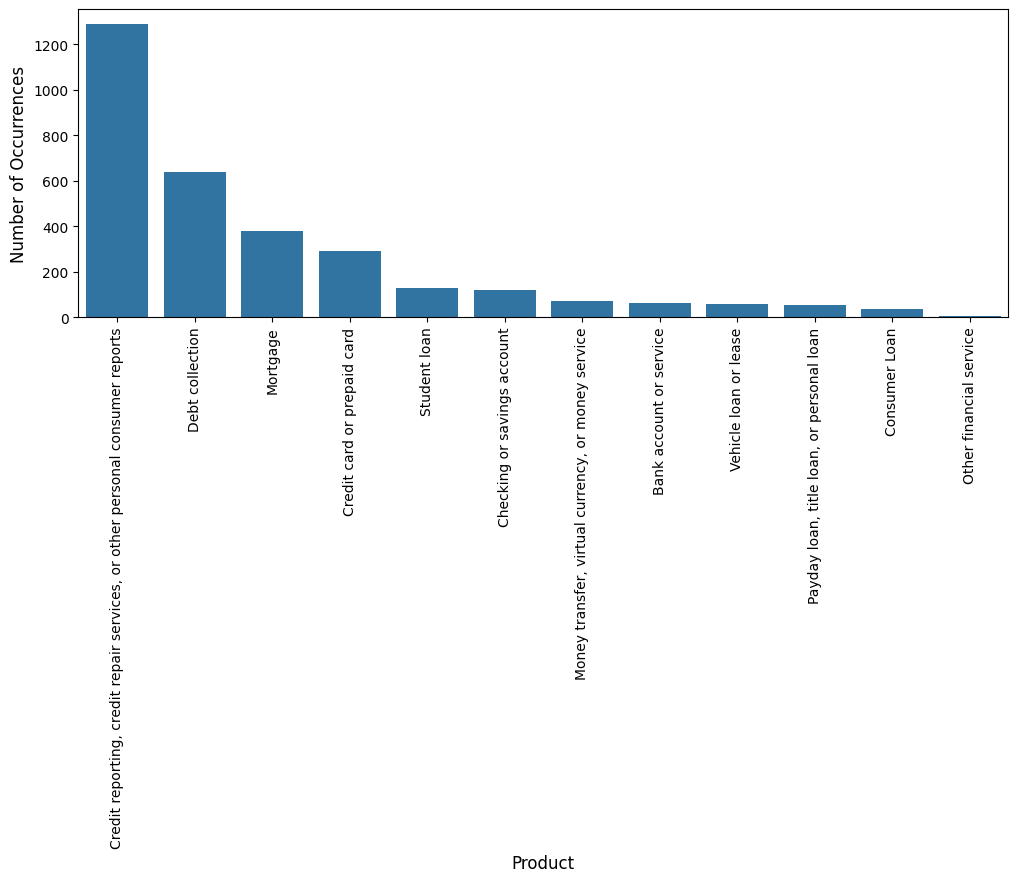

In [50]:
# Plot number of complaints per category
cnt_pro = data['Product'].value_counts()
plt.figure(figsize=(12,4))
sns.countplot(x=data['Product'], order = cnt_pro.index)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Product', fontsize=12)
plt.xticks(rotation=90)
plt.show()

Finally, let's compute the base rate, i.e., the accuracy obtained using a naive classifier that predicts that all observations are from the largest class ("Credit reporting, credit repair services, or other personal consumer reports").

In [51]:
# Base rate
base_rate = round(len(data[data.Product == "Credit reporting, credit repair services, or other personal consumer reports"]) / len (data), 4)
print(f'The base rate is: {base_rate*100:0.2f}%')

The base rate is: 41.12%


### Classification using TF-IDF and Logistic Regression

We first define our training and test set, using the `train_test_split` module of sklearn.

In [52]:
# Select features
X = data['Consumer complaint narrative'] # Features we want to analyze
ylabels = data['Product']                # Labels we test against

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, ylabels, test_size=0.2, random_state=1234)

Next, we use the `TfidfVectorizer` class of sklearn for the word embedding. Since we are dealing with very specific data (e.g., the anonymization process generated non-standard sequence of characters), we are defining our own tokenizer function, which we can use as parameter of `TfidfVectorizer` instead of the default one.

In [53]:
# Define tokenizer function
def spacy_tokenizer(sentence):

    punctuations = string.punctuation
    stop_words = spacy.lang.en.stop_words.STOP_WORDS

    # Create token object, which is used to create documents with linguistic annotations.
    mytokens = sp(sentence)

    # Lemmatize each token and convert each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Remove stop words and punctuation
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # Remove anonymous dates and people
    mytokens = [ word.replace('xx/', '').replace('xxxx/', '').replace('xx', '') for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in ["xxxx", "xx", ""] ]

    # Return preprocessed list of tokens
    return mytokens

As other parameters of `TfidfVectorizer`, we are using token and pair of tokens (`ngram_range = (1,2)`) and we ignore terms that have a document frequency strictly lower than 5 (`min_df = 5`).

Note that we also rely on the `Pipeline` module of sklearn ([Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)) to sequentially apply models, first the vectorizer, then the classifier. We also time our training (it might take a few minutes).

In [54]:
%%time
# Define vectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), tokenizer=spacy_tokenizer)

# Define classifier
classifier = LogisticRegression(solver='lbfgs', max_iter=1000)

# Create pipeline
pipe = Pipeline([('vectorizer', tfidf),
                 ('classifier', classifier)])

# Fit model on training set
pipe.fit(X_train, y_train)

/opt/homebrew/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


CPU times: user 1min 25s, sys: 2.6 s, total: 1min 28s
Wall time: 1min 27s


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(encoding='latin-1', min_df=5,
                                 ngram_range=(1, 2), sublinear_tf=True,
                                 tokenizer=<function spacy_tokenizer at 0x3056a25c0>)),
                ('classifier', LogisticRegression(max_iter=1000))])

Finally, we predict the test set values and evalute the performance of our model:

In [55]:
# Predictions
y_pred = pipe.predict(X_test)

The accuracy using TF-IDF is: 73.73%


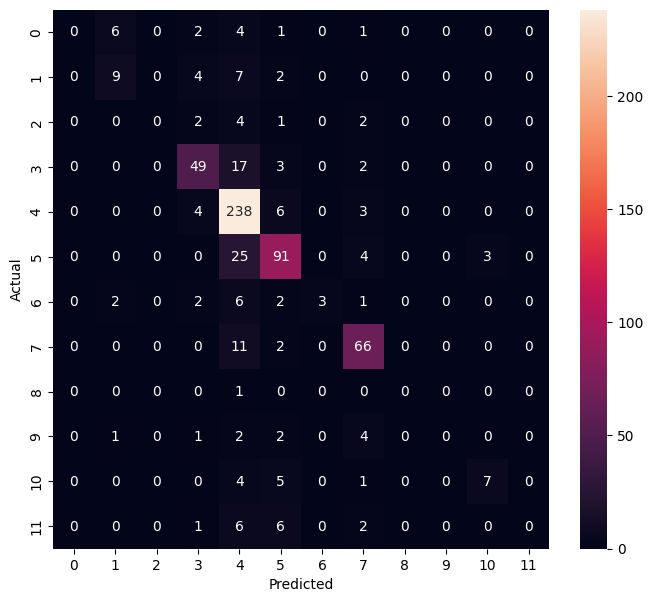

In [56]:
# Evaluate model

## Accuracy
accuracy_tfidf = round(accuracy_score(y_test, y_pred), 4)
print(f'The accuracy using TF-IDF is: {accuracy_tfidf*100:0.2f}%')

## Confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,7))
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Introduction to Hugginface and sentiment analysis
Another powerful tool is the Hugginface library. You can acces the documentation [here](https://huggingface.co/docs)

In our example, we will try to implement a sentiment analysis on a text. A sentiment analysis tries to classify a text into three categories: positive, neutral and negative.

### Implementation of Hugginface
First, we have to load the model that we want to use. There are many differents models that you can find [here](https://huggingface.co/docs/transformers/main_classes/model).

In [57]:
%pip install --upgrade transformers huggingface_hub tensorflow
%pip install --upgrade accelerate
%pip install --upgrade tf-keras

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [58]:
from transformers import pipeline

# Test with a simpler model
sentiment_pipeline = pipeline("sentiment-analysis")


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


Then, we will try to classify these two sentences:

In [59]:
data = ["I love you", "I hate you"]
sentiment_pipeline(data)

[{'label': 'POSITIVE', 'score': 0.9998656511306763},
 {'label': 'NEGATIVE', 'score': 0.9991129040718079}]

This is it! We are already done and we see that the first sentence is obviously classified as *positive* and that the second one is *negative*.

### Your turn !
Try to use this [pipeline](https://huggingface.co/SamLowe/roberta-base-go_emotions) to classify the emotions of this sentence : "I am not having a great day":

In [60]:
# YOUR CODE HERE
#import the model
classifier = pipeline(task="text-classification", model="SamLowe/roberta-base-go_emotions", top_k=None)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [61]:
# print the outputs
sentences = ["I am having a great day"]
model_outputs = classifier(sentences)
print(model_outputs[0])


[{'label': 'joy', 'score': 0.7601534724235535}, {'label': 'excitement', 'score': 0.1981448531150818}, {'label': 'admiration', 'score': 0.06439309567213058}, {'label': 'neutral', 'score': 0.03208456188440323}, {'label': 'approval', 'score': 0.03131645917892456}, {'label': 'gratitude', 'score': 0.02883210778236389}, {'label': 'caring', 'score': 0.020071281120181084}, {'label': 'relief', 'score': 0.01637624204158783}, {'label': 'optimism', 'score': 0.012584558688104153}, {'label': 'love', 'score': 0.00895428191870451}, {'label': 'pride', 'score': 0.008360236883163452}, {'label': 'amusement', 'score': 0.006774324458092451}, {'label': 'desire', 'score': 0.005910138599574566}, {'label': 'annoyance', 'score': 0.003989816177636385}, {'label': 'realization', 'score': 0.003874130081385374}, {'label': 'disapproval', 'score': 0.0024815991055220366}, {'label': 'surprise', 'score': 0.0023469754960387945}, {'label': 'sadness', 'score': 0.0021285698749125004}, {'label': 'curiosity', 'score': 0.0021211

What are the top three emotions related to this sentence : "I don't like clowns, I am afraid of them"

In [62]:
sentences = ["I don't like clowns, I am afraid of them"]
# YOUR CODE HERE
model_outputs = classifier(sentences)
print(model_outputs[0][:3])

[{'label': 'fear', 'score': 0.8777067065238953}, {'label': 'nervousness', 'score': 0.07606003433465958}, {'label': 'disapproval', 'score': 0.05109110847115517}]
